# Como Tunar Hiperparâmetros de Machine Learning Sem Perder Tempo (PythonScikit-Optimize)

Tutorial made from 'Como Tunar Hiperparâmetros de Machine Learning Sem Perder Tempo (Python/Scikit-Optimize)' (Mario Filho - Inteligência Artificial) by Marcus Mariano

**Como Tunar Hiperparâmetros de Machine Learning: [here.](https://www.youtube.com/watch?v=WhnkeasZNHI)**  
**Scikit-Optimize, or skopt: [Doc.](https://scikit-optimize.github.io/)**  
**Referência para aplicações práticas de otimização: [Blog.](https://sigopt.com/blog)**

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
data = pd.read_csv("data/winequality-red.csv")

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
data['quality'].value_counts().sort_index()

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64

In [4]:
data['vinho_bom'] = data['quality'].map(lambda x: 0 if x < 7 else 1)

In [5]:
from lightgbm import LGBMClassifier

In [7]:
?LGBMClassifier

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data.iloc[:, :-2], 
                                                data['vinho_bom'], 
                                                train_size=0.5)

In [8]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((799, 11), (800, 11), (799,), (800,))

In [9]:
Xtrain.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1563,7.2,0.695,0.13,2.0,0.076,12.0,20.0,0.99546,3.29,0.54,10.1
1115,7.0,0.690,0.07,2.5,0.091,15.0,21.0,0.99572,3.38,0.60,11.3
210,9.7,0.530,0.60,2.0,0.039,5.0,19.0,0.99585,3.30,0.86,12.4
216,8.7,0.625,0.16,2.0,0.101,13.0,49.0,0.99620,3.14,0.57,11.0
364,12.8,0.615,0.66,5.8,0.083,7.0,42.0,1.00220,3.07,0.73,10.0


In [10]:
10**7

10000000

10 * 10 * 10 ...

In [11]:
mdl = LGBMClassifier(random_state=0)
mdl.fit(Xtrain, ytrain)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [12]:
from sklearn.metrics import roc_auc_score

p = mdl.predict_proba(Xtest)[:, 1]

In [13]:
roc_auc_score(ytest, p)

0.8824309876209246

# Random search - busca aleatória

1, 2, 3, 4, 5 - [1,2,3,4,5] -> [2], [5]

In [14]:
from skopt import dummy_minimize

C:\Users\marcus\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [29]:
?dummy_minimize

In [17]:
def treinar_modelo(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    mdl = LGBMClassifier(learning_rate = learning_rate, 
                         num_leaves = num_leaves, 
                         min_child_samples = min_child_samples,
                         subsample = subsample, 
                         colsample_bytree = colsample_bytree, 
                         random_state = 0, 
                         subsample_freq = 1, 
                         n_estimators=100)
    
    mdl.fit(Xtrain, ytrain)
    
    p = mdl.predict_proba(Xtest)[:,1]
    
    return -roc_auc_score(ytest, p)

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 128), # num_leaves
         (1, 100), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree

from timeit import default_timer as timer
from datetime import timedelta

# Start Measure time elapsed
start = timer()
# Code here ...

resultado = dummy_minimize(treinar_modelo, 
                           space, 
                           random_state=1, 
                           verbose=1, 
                           n_calls=30)


# End Measure time elapsed
end = timer()
print('\n')
print(timedelta(seconds = end - start))

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 74, 10, 0.3372159440002478, 0.23208030173540176] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1179
Function value obtained: -0.8677
Current minimum: -0.8677
Iteration No: 2 started. Evaluating function at random point.
[0.001529949829431263, 78, 72, 0.3782826906908954, 0.457090726807603] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0580
Function value obtained: -0.8674
Current minimum: -0.8677
Iteration No: 3 started. Evaluating function at random point.
[0.01195730942971637, 128, 19, 0.5483207515942279, 0.49910760440160107] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1169
Function value obtained: -0.8772
Current minimum: -0.8772
Iteration No: 4 started. Evaluating function at random point.
[0.0028784217488024557, 16, 51, 0.9182639233502714, 0.5114843271882895] 

Iteration No: 4 ended. Evaluation done at random point.
Time

In [18]:
resultado.x

[0.014039737029591284, 17, 6, 0.6362876679396877, 0.3939804115948866]

In [30]:
resultado.fun

-0.8899537555873298

In [ ]:
# auc = 0.8924 - [0.03844210597293627, 93, 22, 0.8889692020284521, 0.5867093706408683]

# Bayesian Optimization

In [ ]:
# Meus testes 
[0.014039737029591284, 17, 6, 0.6362876679396877, 0.3939804115948866] -> 0.8900
[0.0011282932078263237, 23, 41, 0.28390051422289364, 0.8740251538145993] -> 0.8553

In [ ]:
[0.03844210597293627, 93, 22, 0.8889692020284521, 0.5867093706408683] -> 0.8924
[0.0011282932078263237, 23, 41, 0.28390051422289364, 0.8740251538145993] -> 0.8398

In [19]:
from skopt import gp_minimize

In [24]:
?gp_minimize

In [20]:
from timeit import default_timer as timer
from datetime import timedelta

# Start Measure time elapsed
start = timer()
# Code here ...

resultados_gp = gp_minimize(treinar_modelo, 
                            space, 
                            random_state = 1, 
                            verbose = 1, 
                            n_calls = 30, 
                            n_random_starts = 10) # 

# End Measure time elapsed
end = timer()
print('\n')
print(timedelta(seconds = end - start))

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 120, 14, 0.9990884895579377, 0.3124800792567785] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1719
Function value obtained: -0.8867
Current minimum: -0.8867
Iteration No: 2 started. Evaluating function at random point.
[0.006210998932353835, 51, 67, 0.9387621172657304, 0.8616798250174156] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0979
Function value obtained: -0.8618
Current minimum: -0.8867
Iteration No: 3 started. Evaluating function at random point.
[0.004232013397179603, 68, 45, 0.2680983530433343, 0.5809725180523154] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0650
Function value obtained: -0.8696
Current minimum: -0.8867
Iteration No: 4 started. Evaluating function at random point.
[0.0672858974212934, 60, 44, 0.9421713999524447, 0.8005503127028804] 

Iteration No: 4 ended. Evaluation done at random point.
Time ta

In [21]:
from skopt.plots import plot_convergence

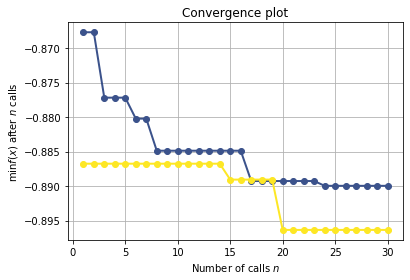

In [22]:
# Meus resultados
plot_convergence(resultado, resultados_gp)

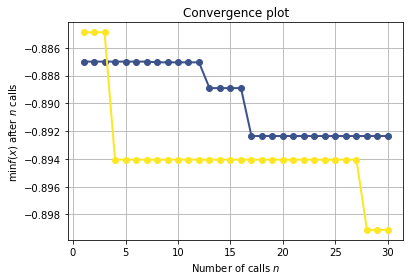

In [40]:
# Não rodar esse aqui
plot_convergence(resultado, resultados_gp)

# exploration exploitation tradeoff

In [23]:
resultados_gp.x

[0.1, 15, 1, 0.7550673694195643, 0.30298725450808667]

In [28]:
resultados_gp.fun

-0.8963429557779753

In [ ]:
# Meus resultados
# auc = 0.8900 -> [0.014039737029591284, 17, 6, 0.6362876679396877, 0.3939804115948866]
# auc_gp = 0.8963 -> [0.1, 15, 1, 0.7550673694195643, 0.30298725450808667]

In [ ]:
# auc = 0.8924 - [0.03844210597293627, 93, 22, 0.8889692020284521, 0.5867093706408683]
# auc = 0.8991 - [0.1, 118, 1, 0.41832604811717616, 0.8614352657429701